In [141]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [142]:
def mackey_glass(N, b=0.1, c=0.2, tau=17):
    y = np.array([0.96, 0.96, 0.97, 1.00, 1.03, 1.07, 1.1, 1.13, 1.14, 1.14, 1.13, 1.12, 1.1, 1.09, 1.08, 1.07, 1.07, 1.07])
    for t in range(17,N-1):
        y_t_plus1  = y[t] -b*y[t] + ( (c*y[t-tau]) / (1 + ( y[t-tau]**10)))
        y = np.append(y, y_t_plus1)
    return y

In [143]:
X = np.arange(1001)
Y = mackey_glass(1001)

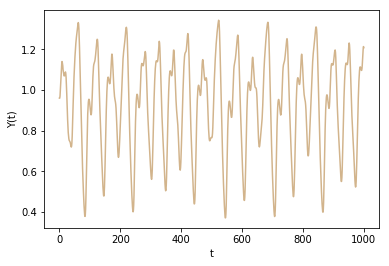

In [144]:
plt.plot(X,Y, color='tan')
plt.xlabel('t')
plt.ylabel('Y(t)')
plt.show()

In [145]:
len(Y)

1001

In [146]:
y_t_plusOne = Y[1:]
df = pd.DataFrame()
df['t'] = X[0:1000]
df['Y(t)'] = Y[0:1000]
df.head(3)

,t,Y(t)
0,0,0.96
1,1,0.96
2,2,0.97


In [147]:
len(Y)

1001

In [148]:
df_train = pd.DataFrame(df[0:400])
df_test = pd.DataFrame(df[450:])
df_validation = pd.DataFrame(df[350:500])
df_train.head(3)

,t,Y(t)
0,0,0.96
1,1,0.96
2,2,0.97


In [149]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 50

series_training = np.array(df_train['Y(t)'])
series_test = np.array(df_test['Y(t)'])
series_validation = np.array(df_validation['Y(t)'])

#RESHAPE SERIES FOR LSTM
series_training = series_training.reshape(len(series_training), 1)
series_test = series_test.reshape(len(series_test), 1)
series_validation = series_validation.reshape(len(series_validation), 1)


generator_training = TimeseriesGenerator(series_training, series_training, length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(series_test, series_test, length=n_input, batch_size=1)
generator_validation = TimeseriesGenerator(series_validation, series_validation, length=n_input, batch_size=1)


In [150]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, 1)))
#model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit_generator(generator_training, steps_per_epoch=1, epochs=400, verbose=0, validation_data=generator_validation)

In [151]:
Y_pred = []
for i in range(0,len(generator_test)):
    x_input = generator_test[i][0].reshape((1, n_input, 1))
    yhat = model.predict(x_input, verbose=0)
    Y_pred = Y_pred + [yhat]
Y_pred = np.reshape(Y_pred, (500,))

In [152]:
Y_valid_pred = []
for i in range(0,len(generator_validation)):
    x_input = generator_validation[i][0].reshape((1, n_input, 1))
    yhat = model.predict(x_input, verbose=0)
    Y_valid_pred = Y_valid_pred + [yhat]
Y_valid_pred = np.reshape(Y_valid_pred, (100,))

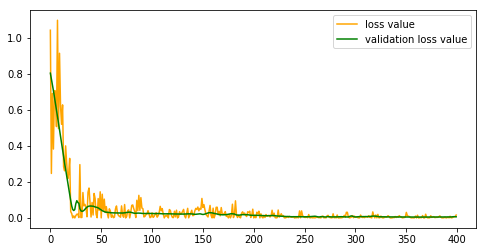

In [153]:
fig = plt.figure(figsize=(8,4))
plt.plot(model.history.history['loss'], color='orange')
plt.plot(model.history.history['val_loss'], color='g')
plt.legend(('loss value', 'validation loss value'))
plt.show()

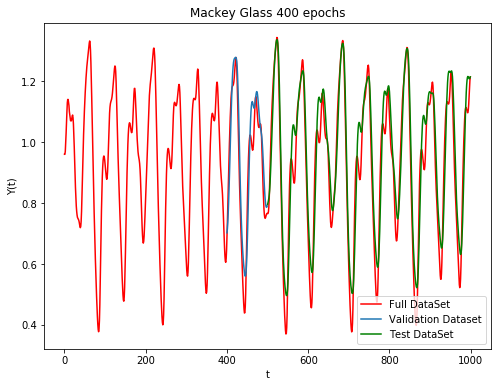

In [155]:
fig = plt.figure(figsize=(8,6))
line1 = plt.plot(df['t'], df['Y(t)'], color='r')
line2 = plt.plot(df_validation['t'][50:], Y_valid_pred)
line3 = plt.plot(df_test['t'][50:], Y_pred, color='g')
plt.legend(('Full DataSet',  'Validation Dataset', 'Test DataSet'), loc='best')
plt.xlabel('t')
plt.ylabel('Y(t)')
plt.title('Mackey Glass 400 epochs')
plt.show()